In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
mon=pd.read_csv("Monero.csv",index_col="Date")

In [ ]:
mon

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
"Oct 11, 2021",276.627,270.239,279.959,265.455,174.47K,2.36%
"Oct 10, 2021",270.239,278.251,282.472,269.599,126.14K,-2.88%
"Oct 09, 2021",278.251,277.680,282.133,273.993,130.12K,0.21%
"Oct 08, 2021",277.680,277.707,286.465,276.276,169.80K,-0.01%
"Oct 07, 2021",277.707,286.533,295.616,275.957,223.20K,-3.08%
...,...,...,...,...,...,...
"May 14, 2016",0.837,0.846,0.854,0.827,2.49K,-1.12%
"May 13, 2016",0.846,0.865,0.878,0.834,2.68K,-2.15%
"May 12, 2016",0.865,0.860,0.877,0.848,3.66K,0.57%


In [ ]:
mon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1981 entries, Oct 11, 2021 to May 10, 2016
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1981 non-null   float64
 1   Open      1981 non-null   float64
 2   High      1981 non-null   float64
 3   Low       1981 non-null   float64
 4   Vol.      1981 non-null   object 
 5   Change %  1981 non-null   object 
dtypes: float64(4), object(2)
memory usage: 108.3+ KB


In [ ]:
mon['Price'] = mon['Price'].replace(',','', regex=True)

In [ ]:
mon.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
"Oct 11, 2021",276.627,270.239,279.959,265.455,174.47K,2.36%
"Oct 10, 2021",270.239,278.251,282.472,269.599,126.14K,-2.88%
"Oct 09, 2021",278.251,277.680,282.133,273.993,130.12K,0.21%
"Oct 08, 2021",277.680,277.707,286.465,276.276,169.80K,-0.01%
"Oct 07, 2021",277.707,286.533,295.616,275.957,223.20K,-3.08%


In [ ]:
mon['Price'] = mon['Price'].astype(float, errors = 'raise')

In [ ]:
reversed(mon.index)

In [ ]:
mon.index[::-1]

Index(['May 10, 2016', 'May 11, 2016', 'May 12, 2016', 'May 13, 2016',
       'May 14, 2016', 'May 15, 2016', 'May 16, 2016', 'May 17, 2016',
       'May 18, 2016', 'May 19, 2016',
       ...
       'Oct 02, 2021', 'Oct 03, 2021', 'Oct 04, 2021', 'Oct 05, 2021',
       'Oct 06, 2021', 'Oct 07, 2021', 'Oct 08, 2021', 'Oct 09, 2021',
       'Oct 10, 2021', 'Oct 11, 2021'],
      dtype='object', name='Date', length=1981)

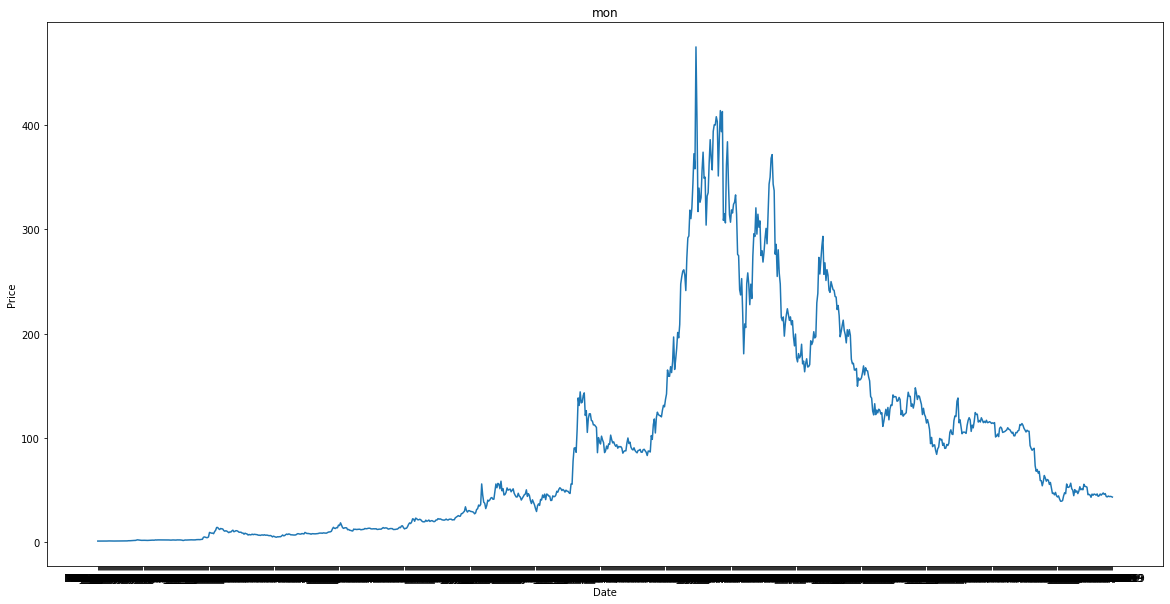

In [ ]:
#mon_trace = go.Scatter(x=mon.index[::-1], y=mon['Price'][::-1], name= 'Price')
#py.iplot([mon_trace])
pyplot.figure(figsize=(20,10))
pyplot.plot(mon.index[::-1][:1000],mon['Price'][::-1][:1000])
pyplot.xlabel("Date")  
pyplot.ylabel("Price") 
pyplot.title("mon")  
pyplot.show()

In [ ]:
#mon_trace = go.Scatter(x=mon.index[::-1], y=mon['Price'][::-1], name= 'Price')
#py.iplot([mon_trace])
from sklearn.preprocessing import MinMaxScaler
values = mon['Price'][::-1].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
train_size = int(len(scaled) * 0.65)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
print(train)
print(scaled)

1287 694
[[4.34892718e-05]
 [1.03546074e-04]
 [1.13900634e-04]
 ...
 [1.26108736e-01]
 [1.25448108e-01]
 [1.25715256e-01]]
[[4.34892718e-05]
 [1.03546074e-04]
 [1.13900634e-04]
 ...
 [5.74558318e-01]
 [5.57966113e-01]
 [5.71195185e-01]]


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX,trainY)

1286
693
[[4.34892718e-05]
 [1.03546074e-04]
 [1.13900634e-04]
 ...
 [1.32781237e-01]
 [1.26108736e-01]
 [1.25448108e-01]] [1.03546074e-04 1.13900634e-04 7.45531870e-05 ... 1.26108736e-01
 1.25448108e-01 1.25715256e-01]


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

[[0.12138969]
 [0.12181178]
 [0.12082485]
 [0.11287095]
 [0.10646839]
 [0.1072045 ]
 [0.09903192]
 [0.10422704]
 [0.10677646]
 [0.11624458]
 [0.11247798]
 [0.11633974]
 [0.11444085]
 [0.11177272]
 [0.11242007]
 [0.11108195]
 [0.10963637]
 [0.11194852]
 [0.1125938 ]
 [0.1131357 ]
 [0.11179548]
 [0.11339011]
 [0.10984937]
 [0.11011615]
 [0.11013063]
 [0.10923724]
 [0.10685297]
 [0.10555239]
 [0.1025214 ]
 [0.09399708]
 [0.09942053]
 [0.09911047]
 [0.09772971]
 [0.09413967]
 [0.09838906]
 [0.09825057]
 [0.0956587 ]
 [0.0962746 ]
 [0.09473073]
 [0.09394128]
 [0.09512341]
 [0.09727497]
 [0.09648129]
 [0.09300718]
 [0.09551403]
 [0.09493534]
 [0.1059618 ]
 [0.10519675]
 [0.11186786]
 [0.12284011]
 [0.12195661]
 [0.12354156]
 [0.1225463 ]
 [0.12169175]
 [0.12146417]
 [0.12331601]
 [0.12058485]
 [0.13046187]
 [0.1423283 ]
 [0.13684987]
 [0.14346717]
 [0.13966763]
 [0.13575473]
 [0.13526824]
 [0.13733637]
 [0.13537385]
 [0.13033147]
 [0.12814592]
 [0.1280383 ]
 [0.1329726 ]
 [0.13645032]
 [0.14

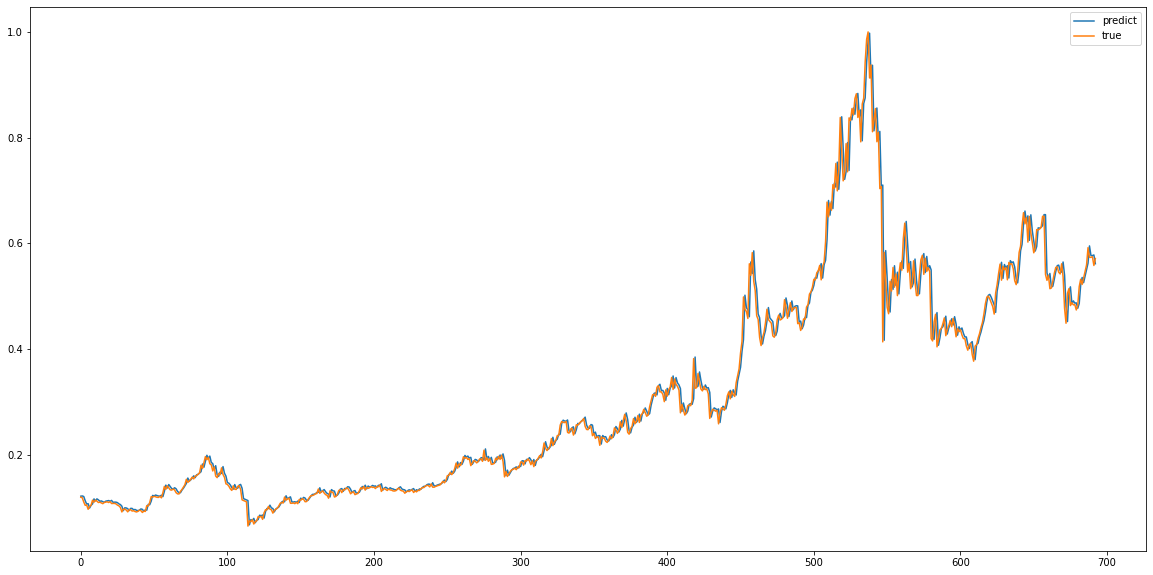

In [ ]:
yhat = model.predict(testX)
print(yhat)
pyplot.figure(figsize=(20,10))
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [ ]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [ ]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.913


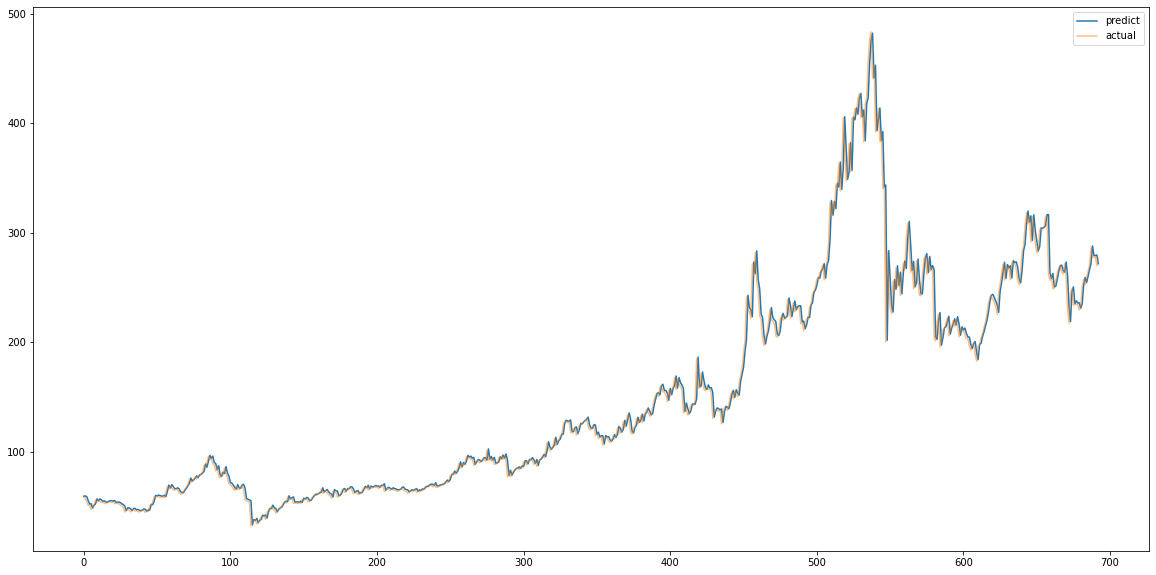

In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [ ]:
predictDates = mon.tail(len(testX)).index

In [ ]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [ ]:
yhat_inverse

array([[ 59.426292],
       [ 59.630104],
       [ 59.15354 ],
       [ 55.312786],
       [ 52.221134],
       [ 52.576588],
       [ 48.630234],
       [ 51.138844],
       [ 52.369896],
       [ 56.941837],
       [ 55.123028],
       [ 56.987785],
       [ 56.070854],
       [ 54.782475],
       [ 55.095066],
       [ 54.448917],
       [ 53.750877],
       [ 54.867367],
       [ 55.178955],
       [ 55.440628],
       [ 54.793465],
       [ 55.563477],
       [ 53.853733],
       [ 53.982555],
       [ 53.989548],
       [ 53.55815 ],
       [ 52.40684 ],
       [ 51.77882 ],
       [ 50.315228],
       [ 46.199024],
       [ 48.817886],
       [ 48.668167],
       [ 48.001427],
       [ 46.267883],
       [ 48.319813],
       [ 48.252937],
       [ 47.00139 ],
       [ 47.29879 ],
       [ 46.55329 ],
       [ 46.17208 ],
       [ 46.74291 ],
       [ 47.78185 ],
       [ 47.398598],
       [ 45.72103 ],
       [ 46.931526],
       [ 46.652092],
       [ 51.976517],
       [ 51.6

In [ ]:
model.save("model.h5")

In [ ]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
model1 = load_model('model.h5')
# summarize model.
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#from 11th OCT 2021 to xth Date
model1.predict([[[0.571195185]]])

array([[0.57454336]], dtype=float32)

In [ ]:
yhat1=[]
prev=0.571195185
#50 means next 50 days from 11th OCT 2021
for i in range(0,50):
  x=model1.predict([[[prev]]])
  yhat1.append(x[0][0])
  prev=x[0][0].item()


In [ ]:
print(yhat1)

[0.57454336, 0.5778894, 0.5812327, 0.5845729, 0.5879095, 0.5912421, 0.59457046, 0.5978939, 0.6012122, 0.6045247, 0.60783094, 0.61113083, 0.61442345, 0.6177084, 0.6209854, 0.62425405, 0.6275137, 0.63076377, 0.634004, 0.637234, 0.6404529, 0.6436606, 0.6468565, 0.65004027, 0.6532115, 0.6563695, 0.65951407, 0.66264474, 0.6657608, 0.6688619, 0.6719479, 0.67501795, 0.6780718, 0.6811093, 0.6841298, 0.68713266, 0.6901177, 0.69308466, 0.69603294, 0.69896233, 0.7018724, 0.70476276, 0.70763296, 0.7104828, 0.713312, 0.7161199, 0.7189066, 0.7216715, 0.72441465, 0.72713524]


In [ ]:
yhat1=np.array(yhat1)

In [ ]:
yhat1_inverse = scaler.inverse_transform(yhat1.reshape(-1, 1))

In [ ]:
yhat1_inverse
#(11th OCT to apna date)

array([[278.24377],
       [279.8595 ],
       [281.4739 ],
       [283.08682],
       [284.698  ],
       [286.3072 ],
       [287.9144 ],
       [289.5192 ],
       [291.12155],
       [292.72107],
       [294.3176 ],
       [295.911  ],
       [297.50095],
       [299.08716],
       [300.66956],
       [302.24792],
       [303.82193],
       [305.39133],
       [306.95596],
       [308.51562],
       [310.06998],
       [311.6189 ],
       [313.1621 ],
       [314.6995 ],
       [316.2308 ],
       [317.75574],
       [319.27417],
       [320.78592],
       [322.2906 ],
       [323.78806],
       [325.2782 ],
       [326.76065],
       [328.23526],
       [329.70203],
       [331.16052],
       [332.61057],
       [334.05197],
       [335.48465],
       [336.9083 ],
       [338.32285],
       [339.72806],
       [341.12372],
       [342.50967],
       [343.8858 ],
       [345.25195],
       [346.60782],
       [347.95346],
       [349.28857],
       [350.61316],
       [351.92688]],

In [ ]:
print(testX)

[[[0.11901788]]

 [[0.11944035]]

 [[0.11845253]]

 [[0.11048983]]

 [[0.10407827]]

 [[0.10481551]]

 [[0.09662917]]

 [[0.10183339]]

 [[0.10438683]]

 [[0.11386751]]

 [[0.11009636]]

 [[0.11396277]]

 [[0.11206166]]

 [[0.10939018]]

 [[0.11003838]]

 [[0.10869849]]

 [[0.10725091]]

 [[0.1095662 ]]

 [[0.11021233]]

 [[0.11075491]]

 [[0.10941296]]

 [[0.11100964]]

 [[0.10746422]]

 [[0.10773137]]

 [[0.10774587]]

 [[0.10685123]]

 [[0.10446345]]

 [[0.10316085]]

 [[0.10012488]]

 [[0.0915844 ]]

 [[0.0970185 ]]

 [[0.09670786]]

 [[0.09532449]]

 [[0.09172729]]

 [[0.09598511]]

 [[0.09584635]]

 [[0.09324943]]

 [[0.09386656]]

 [[0.09231958]]

 [[0.09152848]]

 [[0.09271305]]

 [[0.09486888]]

 [[0.09407365]]

 [[0.09059243]]

 [[0.09310446]]

 [[0.0925246 ]]

 [[0.10357089]]

 [[0.10280465]]

 [[0.10948544]]

 [[0.1204696 ]]

 [[0.11958532]]

 [[0.12117165]]

 [[0.12017553]]

 [[0.11932024]]

 [[0.11909244]]

 [[0.12094592]]

 [[0.1182123 ]]

 [[0.12809682]]

 [[0.13996734]